In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi, sqrt
%matplotlib inline

In [2]:
def gaussian2d(x, y, sx=1, sy=1, x0=0, y0=0, A=1):
    sxx = 2 * sx * sx
    syy = 2 * sy * sy
    xc = x - x0
    yc = y - y0
    xcc = xc * xc
    ycc = yc * yc
    return A * np.exp(-(xcc/sxx + ycc/syy))

In [3]:
def mask_gaussian(size):
    sigma = size / 3.0  # 97% of the gaussian in the size * size square
    half = int((sigma * 5 ) * 2)  # to be sure that the limit of the mask have a value close to 0 (avoid artifact on density map)
    im = np.zeros((2 * half + 1, 2 * half + 1), np.float32)
    for y in range(-half, half + 1):
        for x in range(-half, half + 1):
            im[y + half, x + half] = gaussian2d(x, y, sigma, sigma, 0, 0, 1)
    total_sum = np.sum(im)
    im /= total_sum
    return im

In [4]:
def gaussian2d_gen(x, y, theta, sx=1, sy=1, x0=0, y0=0, A=1):
    """ See https://fr.wikipedia.org/wiki/Fonction_gaussienne
    """    
    assert(sx != 0)
    assert(sy != 0)
    a = (cos(theta)**2) / (2 * sx**2) + (sin(theta)** 2)/ (2 * sy**2)
    b = -sin(2 * theta)/ (4 * sx**2) + sin(2 * theta) / (4 * sy**2)
    c = (sin(theta)**2) / (2 * sx**2) + (cos(theta)** 2)/ (2 * sy**2)
    dx = x - x0
    dy = y - y0
    
    return A * np.exp(-(a * dx**2 + 2 * b * dx * dy + c * dy**2))

In [5]:
0.3**2

0.09

In [243]:
def mask_gaussian(major, minor, theta):
    """ See http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/ for the 5.991
    """
    df = 4.605 #5.991
    sigma_x = major/(2 * sqrt(df))
    sigma_y = minor/(2 * sqrt(df))
    half = int((max(sigma_x, sigma_y) * 3.5 ))  # to be sure that the limit of the mask have a value close to 0 (avoid artifact on density map)
    im = np.zeros((2 * half + 1, 2 * half + 1), np.float32)
    for y in range(-half, half + 1):
        for x in range(-half, half + 1):
            im[y + half, x + half] = gaussian2d_gen(x, y, theta, sigma_x, sigma_y, 0, 0, 1)
    total_sum = np.sum(im)
    im /= total_sum
    return im

Test with ellipse

In [244]:
g = mask_gaussian(100, 30, radians(67))

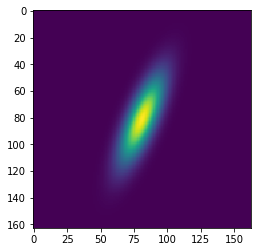

In [245]:
plt.imshow(g)

In [246]:
g.shape[0]//2

81

In [252]:
im = np.zeros(g.shape, dtype=np.uint8)
e = ((g.shape[0]//2, g.shape[0]//2), (100, 30), -67)
im = cv2.ellipse(im, e, color=(255, 255, 255), thickness=-1)

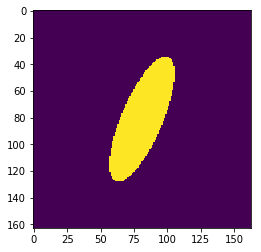

In [253]:
plt.imshow(im)

In [254]:
np.sum(g[im>0])

0.91005051

In [263]:
from math import radians

In [264]:
def create_density_map(shape, ellipses):
    im = np.zeros(shape, np.float32)
    
    # Reweight mask so that the sum is equal to prob
    for es in ellipses:
        for ((xc, yc), (major, minor), theta_deg) in es:
            d = sqrt((3347 - xc)**2 + (2377 - yc)**2)
            if d < 15:
                print((xc, yc), (major, minor), theta_deg)

            
            if d < 15:
                print((xc, yc), (major, minor), theta_deg)
                
            theta_deg = -theta_deg # because axis are not the same for the opencv ellipse
            theta_rad = radians(theta_deg)
            mask = mask_gaussian(major, minor, theta_rad)
    
            hmask, wmask = mask.shape
            hmask2 = hmask//2
            wmask2 = wmask//2
            
            xc = int(round(xc))
            yc = int(round(yc))
            xmin = max(0, xc - wmask2)
            xmax = min(im.shape[1] - 1, xc + wmask2)
            ymin = max(0, yc - hmask2)
            ymax = min(im.shape[0] - 1, yc + hmask2)

            dy_top = yc - ymin
            dy_bottom = ymax - yc
            dx_left = xc - xmin
            dx_right = xmax - xc
            im[ymin:ymax+1, xmin:xmax+1] += mask[hmask2 - dy_top: hmask2 + dy_bottom + 1,\
                                                 wmask2 - dx_left: wmask2 + dx_right + 1] 
    return im

In [265]:
import pickle

In [266]:
train_id = 4
with open("../data/sealion/TrainShape/4.pkl", "rb") as pfile:
    shape = pickle.load(pfile)
with open("../data/sealion/TrainEllipses/4.pkl", "rb") as pfile:
    ellipses = pickle.load(pfile)

In [267]:
dmap = create_density_map(shape, ellipses)

(3348, 2377) (33.99827025153907, 72.0) 118.23426818847656
(3348, 2377) (33.99827025153907, 72.0) 118.23426818847656


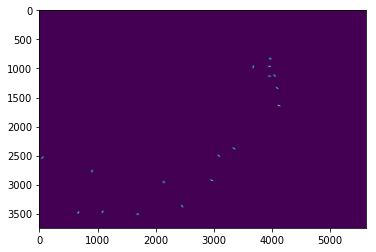

In [268]:
plt.imshow(dmap)

In [269]:
def show_density(im, density):
    max_density = np.max(density)
    normalized_density = density/max_density
    im_fp32 = im.astype(np.float32)
    im_masked = im_fp32.copy()
    im_masked[:,:,0] = (im_fp32[:,:,0] * normalized_density)
    im_masked[:,:,1] = (im_fp32[:,:,1] * normalized_density)
    im_masked[:,:,2] = (im_fp32[:,:,2] * normalized_density)
    return im_masked.astype(np.uint8), (normalized_density * 255).astype(np.uint8)

In [270]:
import cv2

In [271]:
im = cv2.imread("../data/sealion/TrainDotted/4.jpg")

In [272]:
m, d = show_density(im, dmap)

In [280]:
for es in ellipses:
    for e in es:
        cv2.ellipse(m, e, color=(0, 0, 255), thickness=1)

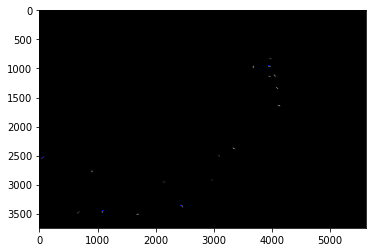

In [281]:
plt.imshow(m)

In [282]:
cv2.imwrite("../data/dmap_ellipses.png", d)
cv2.imwrite("../data/dmap_mask_ellipses.png", m)

True

In [277]:
cv2.imwrite("../data/dmap_check_ellipses.png", d_bgr)

True

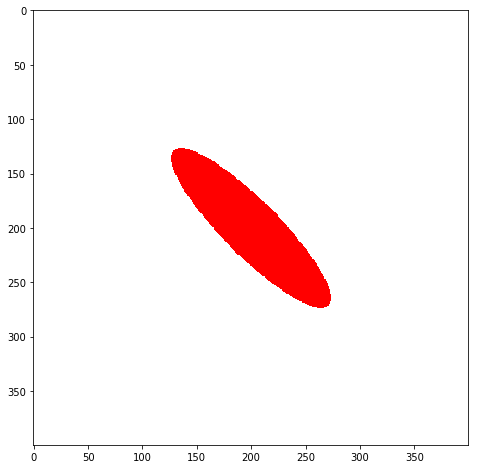

In [188]:
plt.figure(figsize=(8, 8))
im = np.ones((400, 400, 3), dtype=np.uint8) * 255
im = cv2.ellipse(im, ((200, 200), (200, 50), 45), color=(255, 0, 0), thickness=-1)
plt.imshow(im)